In [1]:
import numpy as np # for handling matrices

from qutip import * # for handling quantum mechanical operators, vectors, ...
import matplotlib.pyplot as plt

import time
import random as rand

import networkx as nx # module useful for graph-visualization 

from plot import * # import custom functions for visualization

In [2]:
# it is useful to construct an empty operator in the 2^N dimensional Hilbert space
def operator_list(N): 
    op_list = []
    for i in range(N):
        op_list.append(qeye(2)) # append identity operators which are later substituted by e. g. sigmax() or sigmaz()
    return op_list # the return must still be put into the tensor() function later

In [3]:
# define the problem/driver hamiltonian; J is the interaction matrix of the all-to-all spin glass, b magnetic field
def H_problem(J, offset, b): # the offset is to facilitate the formulation for MaxCut
    N = len(J) # is the number of qubits - the dimension of the Hilbert space is then 2^N
    H_p = 0 # initialize the problem hamiltonian with zero
    
    for i in range(1,N+1,1):
        op_list_2 = operator_list(N) # list in which the operators are stored for every magnetic field
        op_list_2[i-1] = sigmaz() # the ith entry are stores the sigmaz pauli-matrix
        for j in range(i+1,N+1,1):
            op_list_1 = operator_list(N) # list in which the operators are stored for every entry (i,j) of J
            op_list_1[i-1] = sigmaz() # the ith and jth entry are stored with the sigmaz() pauli-matrix
            op_list_1[j-1] = sigmaz()
            
            # iteratively construct the hamiltonian
            H_p = H_p + offset * tensor(operator_list(N)) + J[i-1,j-1] * tensor(op_list_1) 
        H_p = H_p + b[i-1] * tensor(op_list_2)
    return H_p

In [4]:
# define the initial hamiltonian whose eigenstates are easy to construct, N is the number of qubits
def H_initial(N):
    H_0 = 0 # initialize the initial hamiltonian with zero
    
    for i in range(1,N+1,1):
        op_list = operator_list(N) # list in which the operators are stored for qubit
        op_list[i-1] = sigmax()
        
        H_0 = H_0 + tensor(op_list)
    return H_0

In [5]:
# define the time dependent hamiltonian which models the transition from H_0 to H_p
def H_time(t, t_max, H_0, H_p):
    return (1 - t / t_max) * H_0 + (t / t_max) * H_p

In [6]:
def solve_H_time(t_max, iterations, H_0, H_p, N):
    t = np.linspace(0, t_max, iterations)
    
    evals_mat = np.zeros((len(t),2**N)) # matrix for storing the eigenvalues
    for i in range(len(t)):
        H_t = H_time(t[i], t_max, H_0, H_p)
        
        evals, ekets = H_t.eigenstates() # calculate the eigenvalues and eigenstates
        evals_mat[i,:] = np.real(evals)

    return evals_mat.T

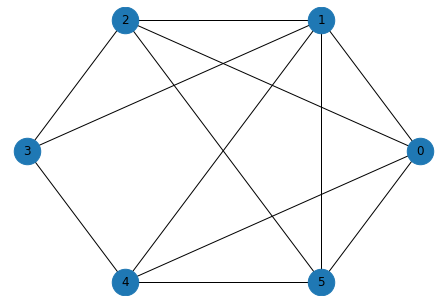

In [7]:
# specifies the interaction matrix in the all-to-all Ising spin glass
J_int = -0.5 * np.array([[0,1,1,0,1,1],
                         [1,0,1,1,1,1],
                         [1,1,0,1,0,1],
                         [0,1,1,0,1,0],
                         [1,1,0,1,0,1],
                         [1,1,1,0,1,0]]) 

J_int = -0.5 * np.array([[0,1,1,0,0],
                         [1,0,1,0,1],
                         [1,1,0,1,0],
                         [0,0,1,0,1],
                         [0,1,0,1,0]]) 

J_int = -0.5 * np.array([[0,1,1,1],
                         [1,0,1,1],
                         [1,1,0,1],
                         [1,1,1,0]])

J_int = -0.5 * np.array([[0,0,0,0,1,0],
                         [0,0,0,1,0,1],
                         [0,0,0,1,0,0],
                         [0,1,1,0,1,0],
                         [1,0,0,1,0,1],
                         [0,1,0,0,1,0]]) 

J_int = -0.5 * np.array([[0,1,1,0,1,1],
                         [1,0,1,1,1,1],
                         [1,1,0,1,0,1],
                         [0,1,1,0,1,0],
                         [1,1,0,1,0,1],
                         [1,1,1,0,1,0]]) 

# J_int = np.array([[1]]) # for 1 qubit system
# J_int = np.random.rand(6,6) # create random Ising matrix

# specifies the local magnetic fields acting on sigmaz_i
b_fields = np.array([0,0,0,0,0,0])
b_fields = np.array([0,0,0,0,0])
b_fields = np.array([0,0,0,0])

b_fields = np.array([0,0,0,0,0,0])
# b_fields = np.array([1]) # for 1 qubit system to validate the algorithm

offset = 0.5 # allows to further modify the hamiltonian to model e. g. MaxCut

graph = nx.from_numpy_matrix(np.matrix(J_int))
nx.draw_circular(graph, node_size=700, with_labels=True)

In [8]:
H_0 = H_initial(len(J_int)) # initial hamiltonian
H_p = H_problem(J_int, offset, b_fields) # problem/driver hamiltonian

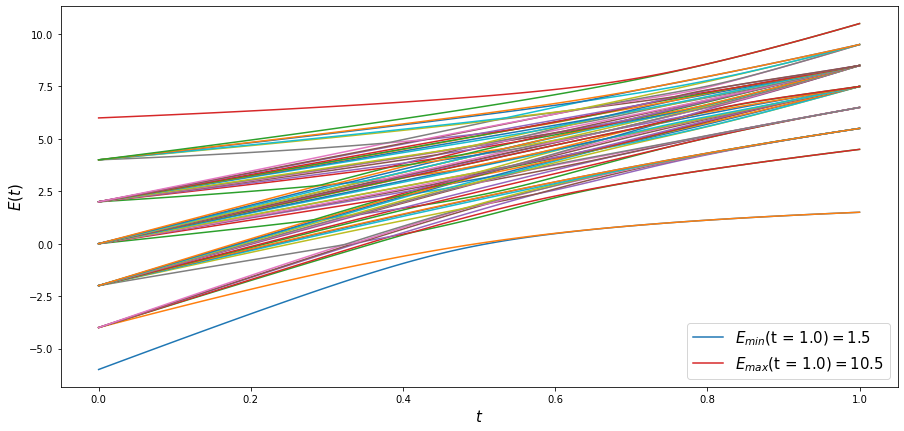

In [9]:
t_max = 1
iterations = 100
t = np.linspace(0, t_max, iterations)

t_evals = solve_H_time(t_max, iterations, H_0, H_p, len(J_int))

image_name = "adiabatic_sweep"
plot_adiabatic_instantaneous_eigenstates(t, t_evals, image_name)

In [10]:
def U_H(H, angle):
    exponential = (-1j*angle*H)
    return exponential.expm()

In [11]:
# function to scan a fine grid of gamma,beta
def qaoa_protocoll_scanning(H_0, H_p, gamma, beta, p):
    initial_evals, initial_ekets = H_0.eigenstates() # calculate eigenvalues and eigenstates
    highest_eval = initial_evals[len(initial_evals)-1] #  last entry is the highest eigenvalue

    initial_ket = initial_ekets[len(initial_evals)-1] # superposition of all |z> vectors - one of them must include the solution
    
    start_t = time.time()
    if p == 1:
        expectation_value = np.zeros((len(gamma), len(beta)))
        for i in range(len(gamma)):
            for j in range(len(beta)):
                gamma_beta_state = U_H(H_0, beta[j]) * U_H(H_p, gamma[i]) * initial_ket
                expectation_value[i,j] = (gamma_beta_state.dag() * H_p * gamma_beta_state)[0,0].real
    elif p == 2:
        expectation_value = np.zeros((len(gamma), len(beta), len(gamma), len(beta)))
        print("Tracking of grid-scanning progress:")
        for i in range(len(gamma)):
            t = time.time()
            print("i = "+str(i)+", delta t = "+str(round(t - start_t,2))+" s")
            start_t = t
            for j in range(len(beta)):
                for k in range(len(gamma)):
                    for l in range(len(beta)):
                        gamma_beta_state = U_H(H_0, beta[l]) * U_H(H_p, gamma[k]) * U_H(H_0, beta[j]) * U_H(H_p, gamma[i]) * initial_ket
                        expectation_value[i,j,k,l] = (gamma_beta_state.dag() * H_p * gamma_beta_state)[0,0].real
    elif p == 3:
        expectation_value = np.zeros((len(gamma), len(beta), len(gamma), len(beta), len(gamma), len(beta)))
        print("Tracking of grid-scanning progress:")
        for i in range(len(gamma)):
            t = time.time()
            print("i = "+str(i)+", delta t = "+str(round(t - start_t,2))+" s")
            start_t = t
            for j in range(len(beta)):
                for k in range(len(gamma)):
                    for l in range(len(beta)):
                        for m in range(len(gamma)):
                            for n in range(len(beta)):
                                gamma_beta_state = U_H(H_0, beta[n]) * U_H(H_p, gamma[m]) * U_H(H_0, beta[l]) * U_H(H_p, gamma[k]) * U_H(H_0, beta[j]) * U_H(H_p, gamma[i]) * initial_ket
                                expectation_value[i,j,k,l,m,n] = (gamma_beta_state.dag() * H_p * gamma_beta_state)[0,0].real
    return expectation_value

In [12]:
p = 1
iterations = 10

gamma = np.linspace(0,2*np.pi,iterations)
beta = np.linspace(0,np.pi,iterations)

exp_values = qaoa_protocoll_scanning(H_0, H_p, gamma, beta, p)

max_exp_value = np.max(exp_values)
ind_max_exp_value = np.unravel_index(np.argmax(exp_values), exp_values.shape) # get index of maximum in graph (corresponds to set of angles for which aprrox ratio is maximal)
print(" ")
print("p = ", p)
print("fineness of grid = ", iterations)
print("maximum expectation value = ", max_exp_value)
# print("index of max expectation value = ", ind_max_exp_value)

print(" ")
print("angle values (may be degenerate): ")
for i in range(p):
    print("gamma_"+str(i+1)+" = ", gamma[ind_max_exp_value[i]])
    print("beta_"+str(i+1)+" = ", beta[ind_max_exp_value[i+1]])

 
p =  1
fineness of grid =  10
maximum expectation value =  8.401062473955417
 
angle values (may be degenerate): 
gamma_1 =  0.6981317007977318
beta_1 =  0.3490658503988659


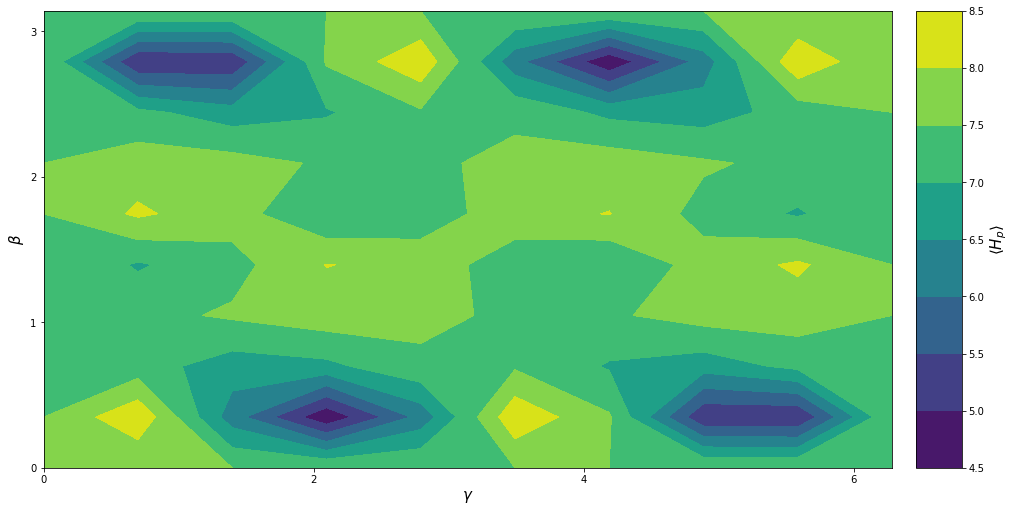

In [13]:
# if initially p=1 was selected it makes sense to plot the energy surface
if p == 1: 
    image_name = "contour_plot_qaoa"
    plot_qaoa_scan_p1(gamma, beta, exp_values, image_name)

In [14]:
# this function allows to determine which additional parameter should be optimized - allows unlimited extension
def statistical_measure(state, choice):
    stat_measure = 0
    if choice == "none": # no additional optimization parameter should be taken into account
        state_measure = 0
    elif choice == "von_neuman_entropy": # calculate von neuman entropy of prob amps
        entropy = 0
        for i in range(state.shape[0]):
            prob_squared = (state[i,0] * np.conj(state[i,0])).real
            entropy = entropy + prob_squared * np.log(prob_squared)
        stat_measure = -entropy
    elif choice == "boltzmann_entropy":
        entropy = 0
        for i in range(state.shape[0]):
            prob_squared = (state[i,0] * np.conj(state[i,0])).real
            entropy = entropy + np.log(prob_squared)
        stat_measure = entropy
    return stat_measure

In [15]:
def monte_carlo_update_state(initial_ket, H_p, p, params):
    evolved_ket = initial_ket
    for i in range(p):
        evolved_ket = U_H(H_0, params[i+1]) * U_H(H_p, params[i]) * evolved_ket    
    expectation_value = (evolved_ket.dag() * H_p * evolved_ket)[0,0].real
    
    return evolved_ket, expectation_value

In [16]:
def get_random_params(params, choice):
    if choice == "lechner_approach":
        rand_param = rand.randint(0,len(params)-1) # generate random index corresponding to random param
        params[rand_param] = 2*np.pi*rand.random() # generates random number in [0,2*pi]
    elif choice == "all_approach":  
        params = 2*np.pi*np.random.rand(len(params)) # generate random array of size 2*p in intervall [0,2*pi]
    return params

In [17]:
# here the monte carlo optimization is performed with M number of random iterations
def qaoa_protocoll_montecarlo(H_0, H_p, p, M, random_approach, opt_approach, optimization_params, control_p):
    initial_evals, initial_ekets = H_0.eigenstates() # calculate eigenvalues and eigenstates
    highest_eval = initial_evals[len(initial_evals)-1] #  last entry is the highest eigenvalue

    initial_ket = initial_ekets[len(initial_evals)-1] # superposition of all |z> vectors - one of them must include the solution
    params_init = np.zeros(2*p)
    
    exp_values = np.zeros(M+1) # initialize an array where the expecation value is defined
    entropy_values = np.zeros(M+1) # initialize an array where the entropy of the amplitude distribution is stored
    stat_values = np.zeros(M+1) #  array for another statistical parameter
    fidelity_values = np.zeros(M+1) # initialize an array where the ground state fidelities can be stored
    
    evals, ekets = H_p.eigenstates() # calculate the eigen-values and eigen-states of the problem hamiltonian
    if opt_approach == "min":
        ground_state = ekets[0] # qutip orders the eigenvalues in ascending order, ground-state could be degenerate
    elif opt_approach == "max":
        ground_state = ekets[len(evals)-1]
    
    # prepare the initial state and calculate interesting parameters
    gamma_beta_state, expectation_value = monte_carlo_update_state(initial_ket, H_p, p, params_init)
    state_entropy = statistical_measure(gamma_beta_state, control_p) # calculate entropy of initial state
    state_statistical = statistical_measure(gamma_beta_state, optimization_params) # calculate other statistical param
    ground_state_fidelity = (gamma_beta_state.dag() * ground_state)[0,0].real # calculate ground-state fidelity
    
    # initialize the "tracking" arrays with the initial values 
    exp_values[0] = expectation_value
    entropy_values[0] = state_entropy
    stat_values[0] = state_statistical
    fidelity_values[0] = np.abs(ground_state_fidelity)
    
    final_state = gamma_beta_state # this is the "optimal" state at the end of the protocoll and always updated
    for i in range(M): # make monte carlo/random updating M times
        params = params_init # define help variable
        params = get_random_params(params, random_approach) # update param according to the two approaches
        
        gamma_beta_state, expectation_value_n = monte_carlo_update_state(initial_ket, H_p, p, params) # new ket
        state_entropy_n = statistical_measure(gamma_beta_state, control_p) # calculate entropy of prob amps
        state_statistical_n = statistical_measure(gamma_beta_state, optimization_params) # calculate other statistical param
        ground_state_fidelity = (final_state.dag() * ground_state)[0,0].real # calculate ground-state fidelity
        if expectation_value_n >= expectation_value and opt_approach == "max" and state_statistical_n <= state_statistical: # just accept value if the condition is fulfilled
            # if new values lead to better state update the parameters and characteristic values
            params_init = params
            expectation_value = expectation_value_n
            state_entropy = state_entropy_n
            state_statistical = state_statistical_n
            final_state = gamma_beta_state
        elif expectation_value_n <= expectation_value and opt_approach == "min" and state_statistical_n <= state_statistical:
            # if new values lead to better state update the parameters and characteristic values
            params_init = params
            expectation_value = expectation_value_n
            state_entropy = state_entropy_n
            state_statistical = state_statistical_n
            final_state = gamma_beta_state
        exp_values[i+1] = expectation_value # store the hopefully monotonous energy change
        entropy_values[i+1] = state_entropy
        stat_values[i+1] = state_statistical
        fidelity_values[i+1] = np.abs(ground_state_fidelity)
    return exp_values, params_init, entropy_values, stat_values, fidelity_values, final_state

In [18]:
# function to calculate the mean and std of the different runs
def calculate_mean(input_multi_dimen_array, parameter_length, len_p_array): 
    mean_array = np.zeros((len_p_array,parameter_length+1)) 
    std_array = np.zeros((len_p_array,parameter_length+1))

    for i in range(parameter_length+1):
        for j in range(len_p_array):
            mean_array[j,i] = np.mean(input_multi_dimen_array.T[i,j])
            std_array[j,i] = np.std(input_multi_dimen_array.T[i,j], ddof=1)
    return mean_array, std_array

In [19]:
# function to run monte-carlo simulation
def run_monte_carlo(H_0, H_p, p_array, M, rand_approach, opt_approach, L, opt_method, control_p):
    # arrays for storing the results of the simulation
    energy = np.zeros((L,len(p_array),M+1))
    entropy = np.zeros((L,len(p_array),M+1))
    stats = np.zeros((L,len(p_array),M+1))
    fidelity = np.zeros((L,len(p_array),M+1))
    
    angles = np.zeros((L,len(p_array),2*np.max(p_array)))
    state_probs = np.zeros((L,len(p_array),H_p.shape[0]), dtype=complex) # H_p.shape[0] gives the length of the state vectors
    
    # iterate the monte-carlo simulation L times
    for i in range(L):
        for j in range(len(p_array)):
            energy[i,j], angle_here, entropy[i,j], stats[i,j], fidelity[i,j], final_state = qaoa_protocoll_montecarlo(H_0, H_p, p_array[j], M, rand_approach, opt_approach, opt_method, control_p)
            angles[i,j] = np.hstack([angle_here, np.zeros(2*np.max(p_array)-2*p_array[j])])
            state_probs[i,j] = (np.array(final_state).T[0] * np.conj(np.array(final_state).T[0])).real
    
    # calculate mean and standard deviation of the characteristic measures
    energy_mean, energy_std = calculate_mean(energy, M, len(p_array))
    entropy_mean, entropy_std = calculate_mean(entropy, M, len(p_array))
    statistical_mean, statistical_std = calculate_mean(stats, M, len(p_array))
    fidelity_mean, fidelity_std = calculate_mean(fidelity, M, len(p_array))
    
    angles_mean, angles_std = calculate_mean(angles, 2*np.max(p_array)-1, len(p_array))
    state_probs_mean, state_probs_std = calculate_mean(state_probs.real, H_p.shape[0]-1, len(p_array))
    
    return energy_mean, energy_std, entropy_mean, entropy_std, statistical_mean, statistical_std, fidelity_mean, fidelity_std, angles_mean, angles_std, state_probs_mean, state_probs_std

In [31]:
L = 10 # number of iterations to perform monte-carlo
M = 100 # number of monte carlo steps

rand_approach = "lechner_approach" # choose kind of random updating, options: "all_approach", "lechner_approach"
opt_approach = "max" # minimization or maximization: "min", "max"

p_array = np.array([1]) # illustrate algorithm for various sizes of angle sets - np.array([1,2,20]) is good

In [32]:
opt_method = "none" # choose if additional parameter should be minimized: "none", "von_neuman_entropy", "var"
control_param = "boltzmann_entropy" # parameter which should be calculated as reference, different from opt_method!

start_t = time.time() # record time needed for compuation
exp_values_1, exp_values_1_std, control_1, control_1_std, stats_1, stats_1_std, fidelity_1, fidelity_1_std, angle_1, angle_1_std, state_probs_1, state_probs_1_std = run_monte_carlo(H_0, H_p, p_array, M, rand_approach, opt_approach, L, opt_method, control_param)
delta_t = time.time() - start_t
print("computation time: ", round(delta_t,2) , "s")

computation time:  6.44 s


In [33]:
opt_method = "von_neuman_entropy" # choose if additional parameter should be minimized: "none", "von_neuman_entropy", "var"
control_param = "von_neuman_entropy" # parameter which should be calculated as reference, different from opt_method!

start_t = time.time() # record time needed for compuation
exp_values_2, exp_values_2_std, control_2, control_2_std, stats_2, stats_2_std, fidelity_2, fidelity_2_std, angle_2, angle_2_std, state_probs_2, state_probs_2_std = run_monte_carlo(H_0, H_p, p_array, M, rand_approach, opt_approach, L, opt_method, control_param)
delta_t = time.time() - start_t
print("computation time: ", round(delta_t,2), "s")

computation time:  8.68 s


In [34]:
opt_method = "boltzmann_entropy" # choose if additional parameter should be minimized: "none", "von_neuman_entropy", "variance"
control_param = "von_neuman_entropy" # parameter which should be calculated as reference, different from opt_method!

start_t = time.time() # record time needed for compuation
exp_values_3, exp_values_3_std, control_3, control_3_std, stats_3, stats_3_std, fidelity_3, fidelity_3_std, angle_3, angle_3_std, state_probs_3, state_probs_3_std = run_monte_carlo(H_0, H_p, p_array, M, rand_approach, opt_approach, L, opt_method, control_param)
delta_t = time.time() - start_t
print("computation time: ", round(delta_t,2), "s")

computation time:  8.85 s


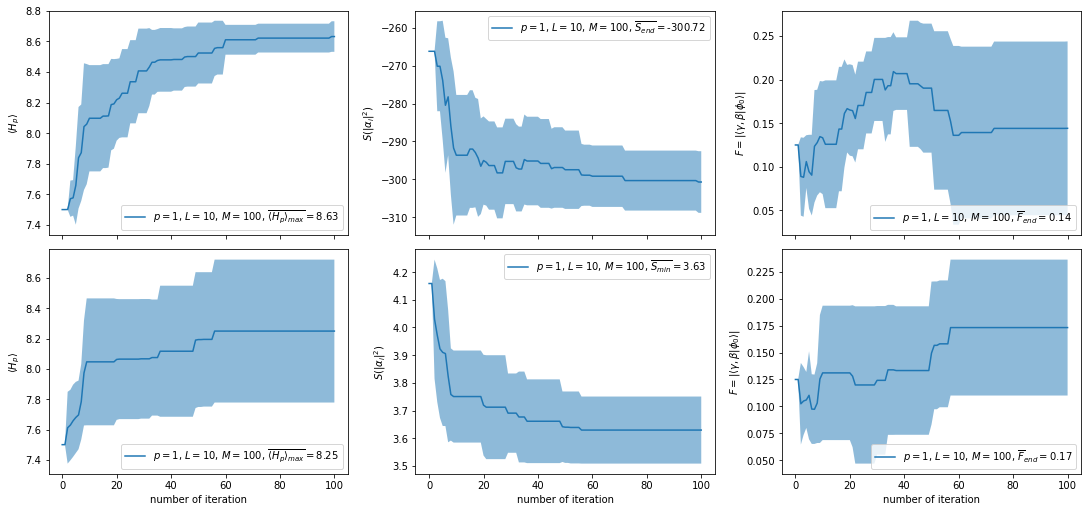

In [35]:
error_bars = "error" # options: "error", "no_error"

# plot settings - labels
y_labels = [r"$\langle H_p \rangle$", r"$S(|\alpha_i|^2)$", r"$F = |\langle \gamma,\beta |\phi_0\rangle|$"]
y_indices = [r", $\overline{S_{end}} = $", r", $\overline{S_{min}} = $", r", $\overline{F}_{end} = $", r", $\overline{F}_{end} = $"]

image_name="energy_entropy_comparison_montecarlo_"+rand_approach+"_"+opt_approach+"_"+opt_method+"_"+error_bars+"_"+str(M)+"_"+str(L)
plot_monte_carlo_simulation_results(exp_values_1, exp_values_1_std, 
                                    exp_values_2, exp_values_2_std, 
                                    control_1, control_1_std, 
                                    stats_2, stats_2_std, 
                                    fidelity_1, fidelity_1_std, 
                                    fidelity_2, fidelity_2_std, 
                                    error_bars, p_array, M, L, y_labels, y_indices, opt_approach, image_name)

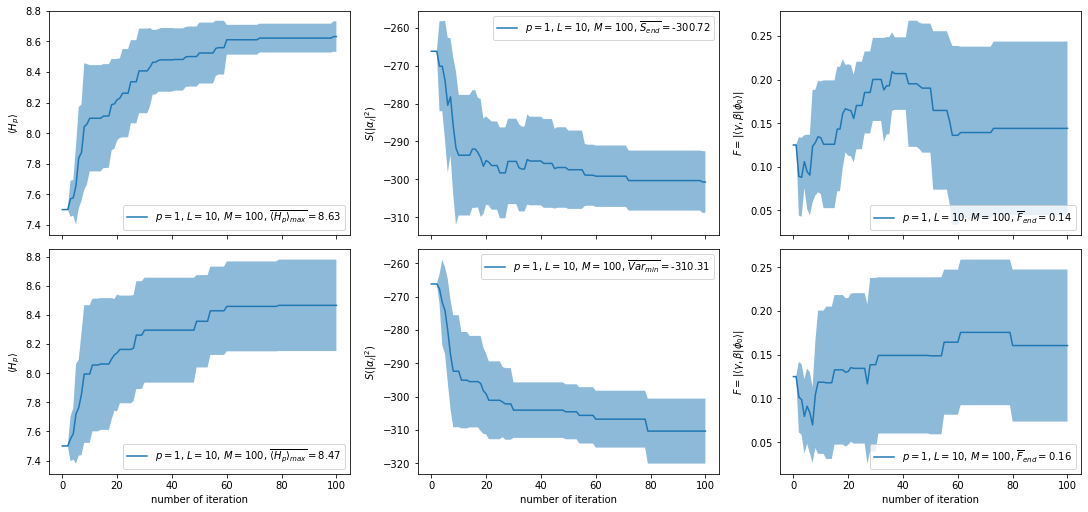

In [36]:
error_bars = "error" # options: "error", "no_error"

# plot settings - labels
y_labels = [r"$\langle H_p \rangle$", r"$S(|\alpha_i|^2)$", r"$F = |\langle \gamma,\beta |\phi_0\rangle|$"]
y_indices = [r", $\overline{S_{end}} = $", r", $\overline{Var_{min}} = $", r", $\overline{F}_{end} = $", r", $\overline{F}_{end} = $"]

image_name="energy_entropy_comparison_montecarlo_"+rand_approach+"_"+opt_approach+"_"+opt_method+"_"+error_bars+"_"+str(M)+"_"+str(L)
plot_monte_carlo_simulation_results(exp_values_1, exp_values_1_std, 
                                    exp_values_3, exp_values_3_std, 
                                    control_1, control_1_std, 
                                    stats_3, stats_3_std, 
                                    fidelity_1, fidelity_1_std, 
                                    fidelity_3, fidelity_3_std, 
                                    error_bars, p_array, M, L, y_labels, y_indices, opt_approach, image_name)

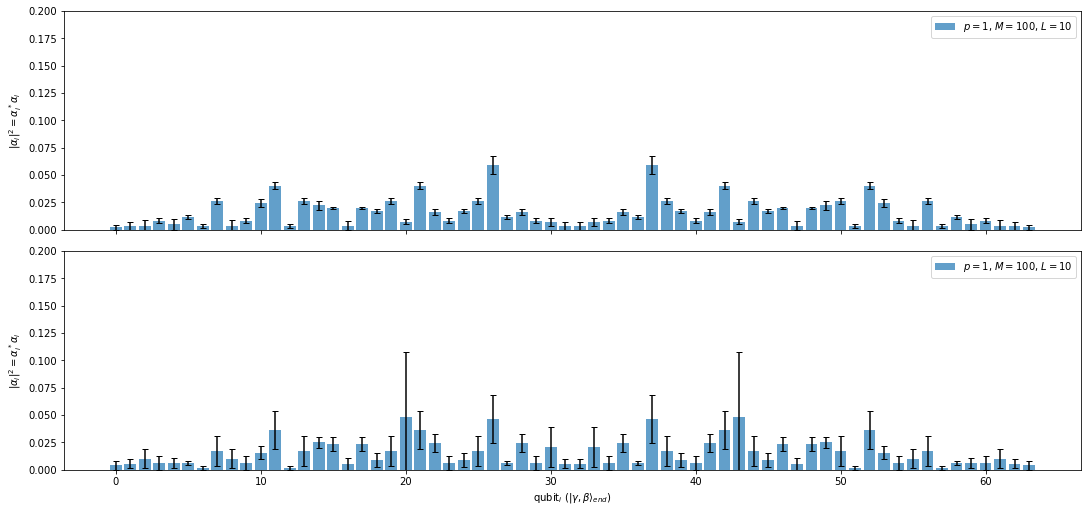

In [26]:
image_name = "average_fock_distribution_final_states_comparison_montecarlo_"+rand_approach+"_"+opt_approach+"_"+opt_method+"_"+str(M)+"_"+str(L)
plot_prob_amplitudes(state_probs_1, state_probs_1_std, 
                     state_probs_2, state_probs_2_std, 
                     p_array, M, L, rand_approach, opt_approach, image_name, 0.3)

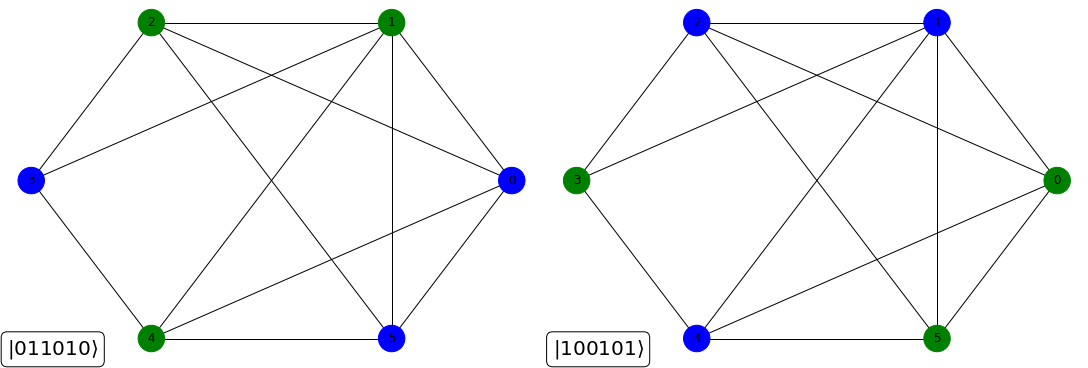

In [27]:
state_choose = state_probs_1[0] # select method/state from which graphical solution should be plotted
threshold = 0.9*np.max(state_choose)

image_size = (15,5) # allows to set image size for optimal representation - size (15,20) is useful for many
image_name = "solution_max_cut_comparison_montecarlo_"+rand_approach+"_"+opt_approach+"_"+opt_method+"_"+str(M)+"_"+str(L)
solution_string, probs_string = plot_solution_graphs(np.log2(H_p.shape[0]), threshold, state_choose, J_int, image_size, image_name)

In [28]:
# calculation of cut size to make senseful comparison to results of adiabatic sweep
def calculate_expectation_value_from_solution_string(solution_string, H_p):
    cut_size = np.zeros(len(solution_string))
    for i in range(len(solution_string)):
        solution_state = ket(solution_string[i]) # create ket of string
        cut_size[i] = (solution_state.dag() * H_p * solution_state)[0,0].real # calculate expectation value 
    return cut_size

In [29]:
# calculation of number of edges between the two subgraphs (not necessarily the expectation value)
def calculate_cut_size(solution_string, J_adj):
    cut_size_d = np.zeros(len(solution_string))
    cut_size_w = np.zeros(len(solution_string))
    edge_number = 0
    for m in range(len(solution_string)):
        cut_size_discrete = 0
        cut_size_weighted = 0
        edge_number = 0
        for i in range(len(J_adj)):
            for j in range(len(J_adj)):
                if J_adj[i,j] != 0:
                    if solution_string[m][i] != solution_string[m][j]: # if the nodes along the edge are disjunct
                        cut_size_discrete += 1 # just count number of separating edges
                        cut_size_weighted += -J_adj[i,j] # make weighted sum with graph weights
                    edge_number += 1
        cut_size_d[m] = cut_size_discrete / 2
        cut_size_w[m] = cut_size_weighted
    return cut_size_d, cut_size_w, edge_number / 2   

In [30]:
print("Solution strings bigger threshold: ", solution_string)
print("Corresponding probabilities: ", probs_string)

exp_value_H_p = calculate_expectation_value_from_solution_string(solution_string, H_p)
print("Corresponding expectation values to H_P: ", exp_value_H_p)

cut_sizes_d, cut_sizes_w, edge_number = calculate_cut_size(solution_string, J_int)
print("Corresponding cut sizes discrete: ", cut_sizes_d)
print("Corresponding cut sizes weighted: ", cut_sizes_w)
print("Control: total edge number: ", edge_number)

Solution strings bigger threshold:  ['011010', '100101']
Corresponding probabilities:  ['0.06', '0.06']
Corresponding expectation values to H_P:  [10.5 10.5]
Corresponding cut sizes discrete:  [9. 9.]
Corresponding cut sizes weighted:  [9. 9.]
Control: total edge number:  12.0
